<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#define-policy---base-class" data-toc-modified-id="define-policy---base-class-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>define policy - base class</a></span></li><li><span><a href="#define-random-policy" data-toc-modified-id="define-random-policy-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>define random policy</a></span></li><li><span><a href="#define-base-class-for-Q-Learning" data-toc-modified-id="define-base-class-for-Q-Learning-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>define base class for Q Learning</a></span></li><li><span><a href="#define-Q-Table-Policy" data-toc-modified-id="define-Q-Table-Policy-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>define Q Table Policy</a></span></li><li><span><a href="#Demo-of-Explore-Rate-Decay" data-toc-modified-id="Demo-of-Explore-Rate-Decay-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Demo of Explore Rate Decay</a></span></li><li><span><a href="#Define-Experiment-Function" data-toc-modified-id="Define-Experiment-Function-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Define Experiment Function</a></span></li><li><span><a href="#Train-and-run-policy-for-Taxi-V2" data-toc-modified-id="Train-and-run-policy-for-Taxi-V2-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Train and run policy for Taxi V2</a></span></li><li><span><a href="#Train-and-run-policy-for-FrozenLake" data-toc-modified-id="Train-and-run-policy-for-FrozenLake-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Train and run policy for FrozenLake</a></span></li></ul></div>

In [1]:
import gym
print('OpenAI Gym:',gym.__version__)
import numpy as np
print('NumPy:',np.__version__)
import matplotlib.pyplot as plt

OpenAI Gym: 0.10.9
NumPy: 1.15.4


## define policy - base class

In [2]:
class policy():
    def __init__(self):
        self.debug = False
        self.learn_mode = False

## define random policy

In [3]:
class policy_random(policy):
    def __init__(self, nA):
        super().__init__()
        self.nA = nA
        self.__name__ = 'random'

    def get_action(self, s=None):
        return np.random.choice(self.nA)

    def update(self, s=None,a=None,r=None,s_=None, done=None):
        pass # the policy does not learn

## define base class for Q Learning

In [4]:
class policy_q(policy):
    def __init__(self,
                 nS,
                 nA,
                 discount_rate=0.9,
                 learning_rate=0.8,
                 explore_rate_max=0.9,
                 explore_rate_min=0.01,
                 explore_rate_decay=0.005):
        super().__init__()
        self.dr = discount_rate
        self.lr = learning_rate
        self.er = explore_rate_max
        self.er_max = explore_rate_max
        self.er_min = explore_rate_min
        self.er_decay = explore_rate_decay

        if not isinstance(nS, np.ndarray):
            self.nS = np.array(nS)
        else:
            self.nS = nS
        if not isinstance(nA, np.ndarray):
            self.nA = np.array(nA)
        else:
            self.nA = nA

    def max_er(self, er_max=None):
        if er_max is not None:
            self.er_max = er_max
        self.er = self.er_max
        return self.er

    def zero_er(self):
        self.er = 0.0
        return self.er

    def decay_er(self, step):
        self.er = self.er_min + (
            self.er_max - self.er_min) * np.exp(
            -self.er_decay * step)
        if self.debug:
            print('New er after decay:', self.er)
        return self.er

## define Q Table Policy

In [5]:
class policy_q_table(policy_q):
    def __init__(self,
                 nS,
                 nA,
                 discount_rate=0.9,
                 learning_rate=0.8,
                 explore_rate_max=0.9,
                 explore_rate_min=0.01,
                 explore_rate_decay=0.005):
        super().__init__(nS, nA, discount_rate, learning_rate,
                         explore_rate_max, explore_rate_min,
                         explore_rate_decay)

        self.__name__ = 'Q_Table'

        # create a q-table of shape (S X A)
        # representing S X A -> R
        self.nQ = np.append(self.nS, self.nA)
        self.q_table = np.zeros(shape=self.nQ)

    def get_action(self, s):
        # Exploration - Select a random action
        if self.learn_mode and np.random.random() < self.er:
            a = np.random.choice(self.nA)
            if self.debug:
                print('Selecting random action ', a)
        # Exploitation - Select the action with the highest q
        else:
            a = self.q_table[s].argmax()
            if self.debug:
                print('Selecting best action ', a)
        return a

    def update(self, s,a,r,s_,done):
        v_s_ = self.q_table[s_].max()
        e_q_sa = r + self.dr * v_s_
        i = tuple(np.append(s, a))
        self.q_table[i] += self.lr * (e_q_sa - self.q_table[i])
        if self.debug:
            print('Updated Q Table')
            print(self.q_table)

## Demo of Explore Rate Decay

In [6]:
# remove the seeds to get random plays everytime
np.random.seed(123)
policy_qt = policy_q_table(2,2)

for i in range(10):
    print(policy_qt.decay_er(i))

0.9
0.8955611064814872
0.8911443520367597
0.8867496262467258
0.8823768192430121
0.878025821705216
0.8736965248581723
0.8693888204692342
0.8651026008455677
0.860837758831459


## Define Experiment Function

In [7]:
# t_max = 0 : run until done
# t_max > 0 : run each episode for t_max steps at max
# g_max = 0 : run until done
# g_max > 0 : run each episode for g_max return at max
from tqdm import trange
import sys
def experiment(env, policy, n_episodes=1, g_max=0, t_max=0, r_max=0, learn_mode = False, debug=False):

    returns = np.zeros(shape=(n_episodes))
    policy.learn_mode = learn_mode

    for i in trange(n_episodes, file=sys.stdout, dynamic_ncols=True ):
        #1. observe initial state
        s = env.reset()

        # initialize the counters
        done = False
        g = 0
        t = 0
        while not done:

            #2. select an action, and observe the next state
            a = policy.get_action(s)
            s_, r, done, _ = env.step(a)
                
            if debug:
                print('SARS=',s,a,r,s_, done)
                #env.render()
            
            #3. update the policy internals
            if policy.learn_mode:
                policy.update(s,a,r,s_, done)

            # set next state as current state
            s = s_

            # update the counters
            g += r
            t += 1
            
            if r_max > 0 and r >= r_max:
                break
            if g_max > 0 and g >= g_max:
                break
            if t_max > 0 and t >= t_max:
                break

        returns[i] = g
        if debug and (i + 1) % 100 == 0:
            print(
                'E#={}, G= Mean:{:0.2f},Min:{:0.2f},Max:{:0.2f}'
                .format(i+1, 
                        returns[:i].mean(),
                        returns[:i].min(), 
                        returns[:i].max()))
        if policy.learn_mode:
            # decay the epsilon i.e. explore rate
            policy.decay_er(i)
    if n_episodes > 1:
        print(
            'Policy:{}, E\'s={}, G= Mean:{:0.2f},Min:{:0.2f},Max:{:0.2f}'.
            format(policy.__name__, n_episodes, np.mean(returns),
                   np.min(returns), np.max(returns)))
        plt.plot(returns)
        plt.title('Training for environment {} with algo {}'.format(env.spec.id,policy.__name__))
        plt.xlabel('Episode #')
        plt.ylabel('Cumulative Rewards (G)')
        plt.show()
    else:
        print('Policy:{}, G= {}'.format(policy.__name__, returns[0]))
    return returns

## Train and run policy for Taxi V2

training policies
  0%|          | 0/10000 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


100%|██████████| 10000/10000 [00:04<00:00, 2169.77it/s]
Policy:Q_Table, E's=10000, G= Mean:0.47,Min:-803.00,Max:15.00


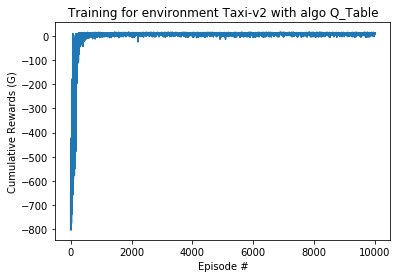

using trained policies
100%|██████████| 1/1 [00:00<00:00, 177.41it/s]
Policy:random, G= -848.0
100%|██████████| 1/1 [00:00<00:00, 746.58it/s]
Policy:Q_Table, G= 13.0


In [8]:
env=gym.make('Taxi-v2')

# remove the seeds to get random plays everytime
np.random.seed(123)
env.seed(123)

policy_rand = policy_random(env.action_space.n)
policy_qt = policy_q_table(env.observation_space.n,env.action_space.n)

print('training policies')
n_episodes = 10000
returns=experiment(env,policy_qt, n_episodes, learn_mode=True)

print('using trained policies')
returns=experiment(env,policy_rand)
returns=experiment(env,policy_qt)

env.close()

## Train and run policy for FrozenLake

training policies
  2%|▏         | 314/20000 [00:00<00:06, 3138.33it/s]

/opt/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


100%|██████████| 20000/20000 [00:18<00:00, 1070.70it/s]
Policy:Q_Table, E's=20000, G= Mean:0.43,Min:0.00,Max:1.00


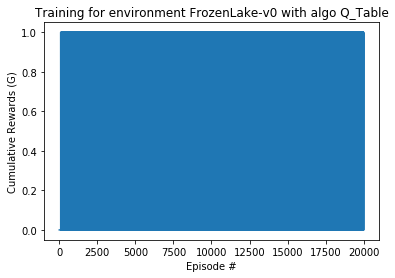

using trained policies
100%|██████████| 1/1 [00:00<00:00, 1032.57it/s]
Policy:random, G= 0.0
100%|██████████| 1/1 [00:00<00:00, 1837.99it/s]
Policy:Q_Table, G= 1.0


In [9]:
env=gym.make('FrozenLake-v0')

# remove the seeds to get random plays everytime
np.random.seed(123)
env.seed(123)

policy_rand = policy_random(env.action_space.n)
policy_qt = policy_q_table(env.observation_space.n,env.action_space.n)

print('training policies')
n_episodes = 20000
returns=experiment(env,policy_qt, n_episodes, learn_mode=True)

print('using trained policies')

returns=experiment(env,policy_rand)
returns=experiment(env,policy_qt)

env.close()

In [ ]:
# Improve the code for calculating expected value for sotchastic policies
#   i.e. where you have to learn probabilities of s_ for s,a

# Run the code on discretized version of pong or CartPole